In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
import tensorflow as tf
from nltk.corpus import stopwords
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
import string
data = pd.read_json("./Sarcasm_Headlines_Dataset_v2.json",lines=True)

In [3]:
import nltk
nltk.download('stopwords')

stwrds = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# remove duplicate headlines
data=data.drop(data[data['headline'].duplicated()].index,axis=0)
sarc_cnt = len(data.query('is_sarcastic==1'))
non_sarc_cnt = len(data.query('is_sarcastic==0'))

# Summary of sarcastic lines
print(f'There are {sarc_cnt} sarcastic headlines and {non_sarc_cnt} non-sarcastic headlines')
# import stopwords from nltk
stwrds = set(stopwords.words('english'))
ps = PorterStemmer()
# method to clean a given headline by lowercasing the string, removing spaces, and removing stopwords
def clean_headlines(headline):
    headline = headline.lower()
    headline_split = headline.split()
    cleaned_headline = []
    for word in headline_split:
        if word not in stwrds and word not in string.punctuation:
            cleaned_headline.append(ps.stem(word))
    cleaned_line = " ".join(cleaned_headline)
    return cleaned_line
data['cleaned'] = data['headline'].apply(clean_headlines)

There are 13552 sarcastic headlines and 14951 non-sarcastic headlines


In [5]:
labels=data.is_sarcastic 
features=data.cleaned

In [6]:
feature_train,feature_test, labels_train,labels_test = train_test_split(features,labels ,test_size =0.2, random_state=123)

In [7]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(feature_train)

vocab_size = len(tokenizer.word_index)
print(vocab_size)

train_sequences = tokenizer.texts_to_sequences(feature_train)
test_sequences = tokenizer.texts_to_sequences(feature_test)

22034


In [8]:
maxlen=max([len(i) for i in train_sequences])

In [9]:
train_padded = pad_sequences(train_sequences, maxlen=maxlen,  padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen,  padding='post')

In [10]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [12]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [13]:
xg_reg.fit(train_padded,labels_train)

preds = xg_reg.predict(test_padded)

[00:41:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [14]:
rmse = np.sqrt(mean_squared_error(labels_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.480490


In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

predictions = [round(value) for value in preds]
# evaluate predictions
accuracy = accuracy_score(labels_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(labels_test, predictions))


Accuracy: 60.52%
              precision    recall  f1-score   support

           0       0.59      0.78      0.67      2971
           1       0.63      0.42      0.50      2730

    accuracy                           0.61      5701
   macro avg       0.61      0.60      0.59      5701
weighted avg       0.61      0.61      0.59      5701



In [28]:
data_dmatrix = xgb.DMatrix(train_padded,labels_train)
data_dtest = xgb.DMatrix(test_padded, labels_test)


params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
               'max_depth': 5, 'alpha': 10}

evallist = [(data_dmatrix, 'train'), (data_dtest, 'eval')]

num_round = 10
bst = xgb.train(params, data_dmatrix, num_round, evallist)

[01:01:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:0.49775	eval-rmse:0.497951
[1]	train-rmse:0.493335	eval-rmse:0.494135
[2]	train-rmse:0.489742	eval-rmse:0.491239
[3]	train-rmse:0.486662	eval-rmse:0.48887
[4]	train-rmse:0.484047	eval-rmse:0.486874
[5]	train-rmse:0.481434	eval-rmse:0.484906
[6]	train-rmse:0.480847	eval-rmse:0.484385
[7]	train-rmse:0.479711	eval-rmse:0.483437
[8]	train-rmse:0.478761	eval-rmse:0.482875
[9]	train-rmse:0.478157	eval-rmse:0.482472


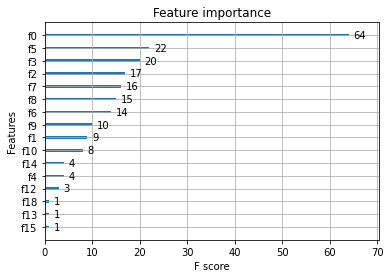

In [30]:
xgb.plot_importance(bst)

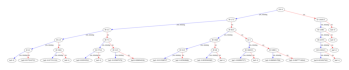

In [31]:
xgb.plot_tree(bst, num_trees=2)

In [32]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

evallist = [(data_dmatrix, 'train'), (data_dtest, 'eval')]

num_round = 10
bst = xgb.train(param, data_dmatrix, num_round, evallist)

[0]	train-auc:0.599198	eval-auc:0.586681
[1]	train-auc:0.63607	eval-auc:0.63049
[2]	train-auc:0.653258	eval-auc:0.637385
[3]	train-auc:0.659442	eval-auc:0.652117
[4]	train-auc:0.665613	eval-auc:0.654364
[5]	train-auc:0.67265	eval-auc:0.65753
[6]	train-auc:0.67841	eval-auc:0.660962
[7]	train-auc:0.68075	eval-auc:0.664278
[8]	train-auc:0.688039	eval-auc:0.672222
[9]	train-auc:0.689636	eval-auc:0.67273


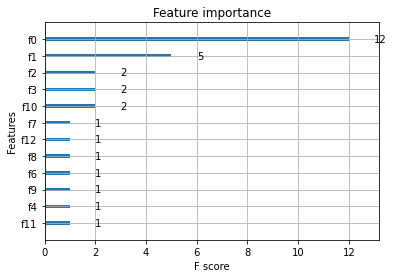

In [33]:
xgb.plot_importance(bst)

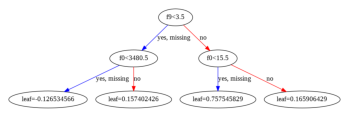

In [34]:
xgb.plot_tree(bst, num_trees=2)